
* https://en.wikipedia.org/wiki/Bump_mapping
* https://web.archive.org/web/20060924191232/http://freespace.virgin.net/hugo.elias/graphics/x_polybm.htm

In [1]:
from PIL import Image as pil_image  # pillow probably?
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

In [2]:
xx, yy = np.meshgrid(np.arange(200), np.arange(200))

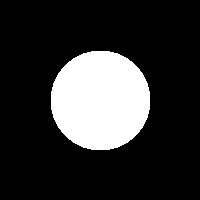

In [3]:
xcent, ycent, rad = 100, 100, 50
circle = ((xx - xcent)**2 + (yy - ycent)**2) < rad**2
pil_image.fromarray(circle)

## Bump/Depth Map

sphere:
$$x^2 + y^2 + z^2 = r^2 \\
z^2 = r^2 - x^2 - y^2 \\
$$

In [4]:
# select pixels in the sphere projection
# (already what the `circle` bool array is)

# for each, where x/y is given, compute z
zsq = rad**2 - (xx-xcent)**2 - (yy-ycent)**2
z = np.sqrt(np.clip(zsq, 0, None))

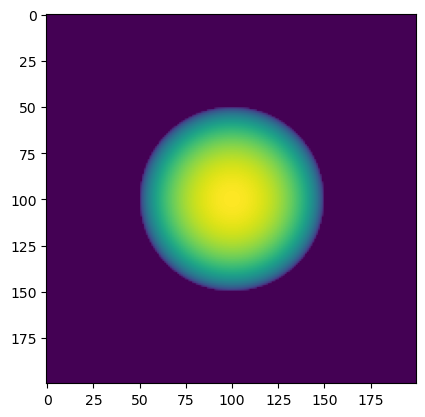

In [5]:
plt.imshow(z)

## (Hemi)sphere Normals

Can add some additional data into the map by defining the normal vector for each point. Assuming the depth map was 'smooth' and had no discontinuities, I think this would be equivalent, but additional information will be added into the normal map as you wind up with 2 independent variables per point. 

Building it from the ideal geometry, rather than differentating the depth map should give more ideal results. I think some of these assumptions are why the built-in "bump map" filter in GIMP can give crappy results

In [6]:
# then scale that to get the normal vector out from the center
xvec = (xx - xcent).astype('float64')
yvec = (yy - ycent).astype('float64')
zvec = z - 0
veclen = np.sqrt(xvec**2 + yvec**2 + zvec**2)
xvec /= veclen
yvec /= veclen
zvec /= veclen

xvec[z==0] = 0
yvec[z==0] = 0
zvec[z==0] = 1

normals = np.dstack((xvec, yvec, zvec))

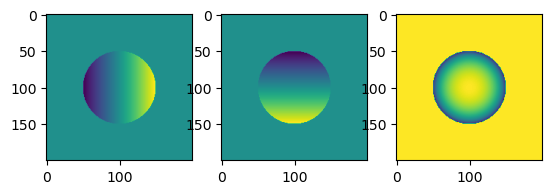

In [7]:
f, axs = plt.subplots(1, 3)
axs[0].imshow(xvec)
axs[1].imshow(yvec)
axs[2].imshow(zvec)

```
  X: -1 to +1 :  Red:     0 to 255
  Y: -1 to +1 :  Green:   0 to 255
  Z:  0 to -1 :  Blue:  128 to 255
```

In [8]:
min50max = [0, 50, 100]
np.percentile(xvec, min50max), np.percentile(yvec, min50max), np.percentile(zvec, min50max)

(array([-0.98,  0.  ,  0.98]),
 array([-0.98,  0.  ,  0.98]),
 array([0.02828427, 1.        , 1.        ]))

In [9]:
r = ((xvec + 1) * 255/2).astype("uint8")
g = ((yvec + 1) * 255/2).astype("uint8")
b = ((zvec + 1) * 255/2).astype("uint8")

np.percentile(r, min50max), np.percentile(g, min50max), np.percentile(b, min50max)

(array([  2., 127., 252.]),
 array([  2., 127., 252.]),
 array([131., 255., 255.]))

In [10]:
norm_colors = np.dstack((r, g, b))

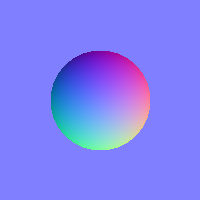

In [11]:
pil_image.fromarray(norm_colors)

Looks OK, but upside-down? Unsure if some of my coordinates are backwards or if I computed the normal map for the 'wrong' surface of the sphere

## Shading

* https://en.wikipedia.org/wiki/Phong_reflection_model

Phong is roughly: ambient + diffuse + specular. Ambient is constant if the surface is constant, i.e. there's no angle math or anything. Diffuse is for a fully matte object, and specular gives the shine.

$$ I_{\text{p}} \
=k_{\text{a}}i_{\text{a}} \
+\sum _{m\;\in \;{\text{lights}}}\
\left(\
  k_{\text{d}}({\hat L}_m\cdot {\hat N})i_{m,{\text{d}}}+\
  k_{\text{s}}({\hat R}_m\cdot {\hat V})^{\alpha }i_{m,{\text{s}}}\
\right)$$

* $k$: Reflection constants/ratio of reflection
    * $k_\text{a}$: Ambient
    * $k_\text{d}$: Diffuse
    * $k_\text{s}$: Specular
* $i$: Intensity (and color) of light(s).
* Diffuse terms
    * $\hat L_m$: Surface point to light $m$. For our purposes, the light will be infinitely far away, so this would be a constant.
    * $\hat N$: Normal. From the normal map.
* Specular terms
    * $\hat R_m$: The reflection of $\hat L_m$ off the surface. Can be computed as below.
    * $\hat V$: Surface to viewer. For us, again, constant. Straight up.
    * $\alpha$: "Shinyness" exponent. If this is large, it will increase how 'picky' the specular light rays are because they'll need to align more closely with the ideal reflection angle. Larger exponents will force any unit vector dot products (all <1) that are only close to 1 to be very-not-1. i.e. 

$$
{\hat R}_m = 2({\hat L}_m \cdot \hat N)\hat N - {\hat L}_m
$$

The "for our purposes" simplifications is actually what *Blinn-Phong* is, where the viewer and light are at infinity. Our performance isn't really a concern though, and I can't find the equations for it to implement...

In [12]:
# light stuff
l_angle_vert_deg = 45
l_angle_horiz_deg = 45

l_x = np.cos(np.deg2rad(l_angle_horiz_deg)) 
l_y = np.sin(np.deg2rad(l_angle_horiz_deg))
l_z = np.tan(np.deg2rad(l_angle_vert_deg))
l_vec = np.array([l_x, l_y, l_z])
l_vec /= np.linalg.norm(l_vec)
l_vec

array([0.5       , 0.5       , 0.70710678])

In [13]:
diffuse = np.tensordot(l_vec, normals, axes=(0, 2))
reflect = 2 * np.expand_dims(diffuse, axis=-1) * normals - l_vec
diffuse = diffuse.clip(0, None) # or else the 'back' will also be lit

# mask
diffuse[z==0] = 0
reflect[z==0] = np.array([0, 0, 0])

diffuse.shape, reflect.shape

((200, 200), (200, 200, 3))

In [14]:
v_vec = np.array([0, 0, 1])  # from above
specular_pre = np.tensordot(reflect, v_vec, axes=(2, 0))
specular_pre = specular_pre.clip(0, None) # or else the 'back' will also be shiny
specular_pre.shape

(200, 200)

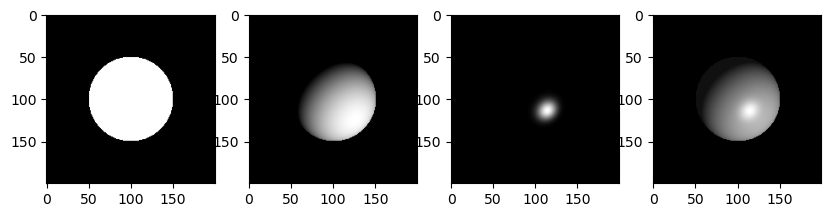

In [24]:
k_ambient = 0.2
k_diffuse = 2
k_specular = 1
specular_alpha = 10

ambient = (z!=0).astype('float64')
specular = specular_pre ** specular_alpha

image = k_ambient * ambient + k_diffuse * diffuse + k_specular * specular

f, axs = plt.subplots(1, 4)
f.set_size_inches(10, 3)
axs[0].imshow(ambient, cmap="binary_r")
axs[1].imshow(diffuse, cmap="binary_r")
axs[2].imshow(specular, cmap="binary_r")
axs[3].imshow(image, cmap="binary_r")

...as an aside, refreshing myself on how to do the math. Not sure how to multiply out the 2-D greyscale to an RGB image.

In [16]:
x = np.array([
    [1.0, 0.0,],# 0.0, 0.0],
    [0.5, 1.0,],# 0.0, 0.1],
    #[1.0, 0.0, 0.3, 0.4],
    #[0.9, 0.8, 0.7, 0.6],
])
green = np.array(colors.to_rgb(colors.XKCD_COLORS["xkcd:green"]))
green, x

(array([0.08235294, 0.69019608, 0.10196078]),
 array([[1. , 0. ],
        [0.5, 1. ]]))

In [17]:
x.shape, green.shape  # to dot-product/multiply them, shove in a sham dimension on either side:

((2, 2), (3,))

In [18]:
greenx = np.expand_dims(green, 0)
greenx.shape
(np.expand_dims(x, -1) @ greenx).shape

(2, 2, 3)

OK, got it...

In [19]:
def color_array(img, color):
    if isinstance(color, str):
        hex_color = colors.get_named_colors_mapping()[color]
        color = colors.to_rgb(hex_color)
        color = np.array(color)
    color = np.expand_dims(color, 0)
    assert color.shape == (1, 3)
        
    if img.ndim == 3 and img.shape[-1] != 1:
        raise ValueError("img expected to be 2-D or 3-D with final dimension size 1", img.shape)
    elif img.ndim != 2:
        raise ValueError("img expected to be 2-D or 3-D with final dimension size 1", img.shape)
    else:
        img = np.expand_dims(img, -1)
    assert img.ndim == 3
    assert img.shape[-1] == 1
    
    return img @ color

color_array(x, "xkcd:green")

array([[[0.08235294, 0.69019608, 0.10196078],
        [0.        , 0.        , 0.        ]],

       [[0.04117647, 0.34509804, 0.05098039],
        [0.08235294, 0.69019608, 0.10196078]]])

In [20]:
def img_float_to_byte(array, rescale=1):
    """
    *rescale* is kinda like an exposure setting. Default of 1 will be scaled with 
    brightest point hitting 255 (in a single channel), but can 'overexpose' by bumping
    it up.
    """
    if array.ndim != 3:
        raise ValueError("expecting 3D array with dims x, y, color", array.shape)
    if array.shape[-1] != 3:
        raise ValueError("expecting 3D array with dims x, y, color", array.shape)
        
    scaled = array * 255 / np.max(array)
    rescaled = np.clip(scaled * rescale, 0, 255)
        
    return rescaled.astype('uint8')

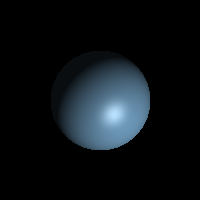

In [21]:
img = (
    k_ambient  * color_array(ambient,  "xkcd:light blue") +
    k_diffuse  * color_array(diffuse,  "xkcd:light blue") +
    k_specular * color_array(specular, "xkcd:white")
)
pil_image.fromarray(img_float_to_byte(img, 1))

In [22]:
class DirectionalLight:
    def __init__(self, color, direction):
        if isinstance(color, str):
            hex_color = colors.get_named_colors_mapping()[color]
            color = colors.to_rgb(hex_color)
        color = np.array(color)
        if color.shape != (3,):
            raise ValueError("color_rgb must be a 1D, 3-element array (RGB)", color.shape)
        self._color = color
        
        direction = np.array(direction)
        if direction.shape != (3,):
            raise ValueError("direction must be a 1D, 3-element array; a vector pointing at the light", direction.shape)
        direction = direction / np.linalg.norm(direction)  # unitize
        self._direction = direction

    def __repr__(self):
        return f"{self.__class__.__name__}(color={self._color!r}, direction={self._direction!r})"
    
#     def 
        
def flat_phong(normal_map, directional_lights, ambient_light):
    pass

In [23]:
DirectionalLight("xkcd:green", [1,1,1])

DirectionalLight(color=array([0.08235294, 0.69019608, 0.10196078]), direction=array([0.57735027, 0.57735027, 0.57735027]))